In [3]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [4]:
import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from polars import col

from src.data.database_manager import DatabaseManager
from src.features.scaling import scale_min_max
from src.features.transforming import map_by_group
from src.log_config import configure_logging
from src.plots.averages_over_stimulus_seeds import (
    add_ci_to_averages,
    average_over_stimulus_seeds,
    calculate_max_crosscorr_lag_over_averages,
    plot_averages_with_ci,
)

configure_logging(
    ignore_libs=("Comm", "bokeh", "tornado", "matplotlib"),
)

pl.Config.set_tbl_rows(12)  # for 12 seeds
hv.output(widget_location="bottom", size=150)

In [5]:
db = DatabaseManager()

In [6]:
with db:
    df = db.get_table(
        "Merged_and_Labeled_Data",
        exclude_trials_with_measurement_problems=True,
    )
df

trial_id,trial_number,participant_id,timestamp,temperature,rating,eda_raw,eda_tonic,eda_phasic,ppg_raw,ppg_ibi_shimmer,heartrate,pupil_l_raw,pupil_r_raw,pupil_r,pupil_l,pupil_mean,pupil_mean_tonic,brow_furrow,cheek_raise,mouth_open,upper_lip_raise,nose_wrinkle,normalized_timestamp,stimulus_seed,skin_patch,decreasing_intervals,major_decreasing_intervals,increasing_intervals,strictly_increasing_intervals,strictly_increasing_intervals_without_plateaus,plateau_intervals,prolonged_minima_intervals
u16,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u16,u8,u16,u16,u16,u16,u16,u16,u16
1,1,1,294198.9762,0.0,0.425,0.743774,0.743503,0.000271,1408.404382,-1.062977,65.243881,5.670313,6.173421,5.641376,5.15944,5.400408,5.350094,0.00036,0.00286,0.0048,0.0,0.00007,0.0,396,1,0,0,1,0,0,0,0
1,1,1,294298.9762,0.000039,0.425,0.744641,0.743517,0.001124,1372.864366,-0.131651,65.242949,5.602895,6.142564,5.639922,5.157792,5.398857,5.343983,0.00036,0.00286,0.0048,0.0,0.00007,100.0,396,1,0,0,1,0,0,0,0
1,1,1,294398.9762,0.000154,0.395798,0.74488,0.743537,0.001343,1397.15563,-2.948082,65.241069,5.518026,6.072123,5.643301,5.160338,5.401819,5.337462,0.000341,0.002327,0.004199,0.0,0.000065,200.0,396,1,0,0,1,0,0,0,0
1,1,1,294498.9762,0.000417,0.270286,0.744808,0.743557,0.001252,1485.360361,1.488009,65.238629,5.399583,5.947853,5.638149,5.156922,5.397535,5.330919,0.000512,0.00122,0.002504,0.0,0.000065,300.0,396,1,0,0,1,0,0,0,0
1,1,1,294598.9762,0.000818,0.129521,0.74487,0.743578,0.001293,1496.64849,-4.735116,65.235505,5.276378,5.796069,5.646014,5.1618,5.403907,5.324177,0.001059,0.000701,0.002202,0.000006,0.000093,400.0,396,1,0,0,1,0,0,0,0
1,1,1,294698.9762,0.001358,0.152477,0.744957,0.743594,0.001363,1456.946658,1.28125,65.233139,5.158002,5.642459,5.62452,5.146081,5.3853,5.317484,0.001138,0.000565,0.001937,0.000017,0.00009,500.0,396,1,0,0,1,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
516,12,50,2.6956e6,0.031312,0.0,26.688608,26.716225,0.003169,1323.813266,-5.036073,59.279672,5.166699,4.766597,4.768156,5.167254,4.967705,5.180142,0.000465,0.001124,0.007081,0.00022,0.004168,179500.0,806,1,2580,1548,0,0,0,0,0
516,12,50,2.6957e6,0.030874,0.0,26.68499,26.716212,0.000389,1244.871959,44.337204,58.673362,5.026438,4.683481,4.690238,5.025632,4.857935,5.174284,0.000698,0.000846,0.007044,0.000348,0.004289,179600.0,806,1,2580,1548,0,0,0,0,0


In [7]:
signals = [
    "temperature",
    "rating",
    "heartrate",
    "pupil_mean",
    "pupil_mean_tonic",
    "eda_tonic",
    "eda_phasic",
]


## Averaged trials over stimulus seeds with confidence intervals

In [8]:
averages = average_over_stimulus_seeds(
    df,
    signals,
    scaling="min_max",
    bin_size=0.1,
)
averges_with_ci = add_ci_to_averages(
    averages,
    signals,
    confidence_level=0.95,
)
plot_averages_with_ci(
    averges_with_ci,
    signals,
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'5f6ee1ce-a408-45c1-9f18-06f50393cbd6': {'version…

In [9]:
averages

stimulus_seed,avg_temperature,avg_rating,avg_heartrate,avg_pupil_mean,avg_pupil_mean_tonic,avg_eda_tonic,avg_eda_phasic,std_temperature,std_rating,std_heartrate,std_pupil_mean,std_pupil_mean_tonic,std_eda_tonic,std_eda_phasic,sample_size,time_bin
u16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,f64
133,0.0,0.36777,0.71856,0.740378,0.774158,0.864278,0.376851,0.0,0.245469,0.211737,0.249832,0.251752,0.172527,0.22937,37,0.0
133,0.000184,0.380709,0.721233,0.754081,0.776229,0.865082,0.394253,0.000025,0.247465,0.209718,0.247072,0.247999,0.170686,0.220318,37,0.1
133,0.000784,0.400342,0.725001,0.765688,0.778089,0.865836,0.416049,0.000087,0.245996,0.208713,0.2431,0.244141,0.16892,0.218395,37,0.2
133,0.001871,0.419517,0.728698,0.781008,0.779639,0.866661,0.438784,0.000143,0.246142,0.207712,0.232752,0.240436,0.16705,0.224019,37,0.3
133,0.003444,0.43083,0.732501,0.793537,0.780857,0.867375,0.466225,0.000197,0.248252,0.207539,0.22617,0.236763,0.165337,0.233374,37,0.4
133,0.005515,0.443373,0.734556,0.802454,0.781671,0.868132,0.494152,0.00028,0.247539,0.20741,0.221985,0.233246,0.163416,0.240949,37,0.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
952,0.055794,0.045383,0.4201,0.313471,0.288954,0.181705,0.40901,0.000191,0.126091,0.195674,0.222986,0.234831,0.222388,0.107579,40,179.4
952,0.055265,0.042738,0.421209,0.307955,0.288236,0.181679,0.409845,0.00015,0.123876,0.193765,0.225619,0.235284,0.222381,0.10366,40,179.5


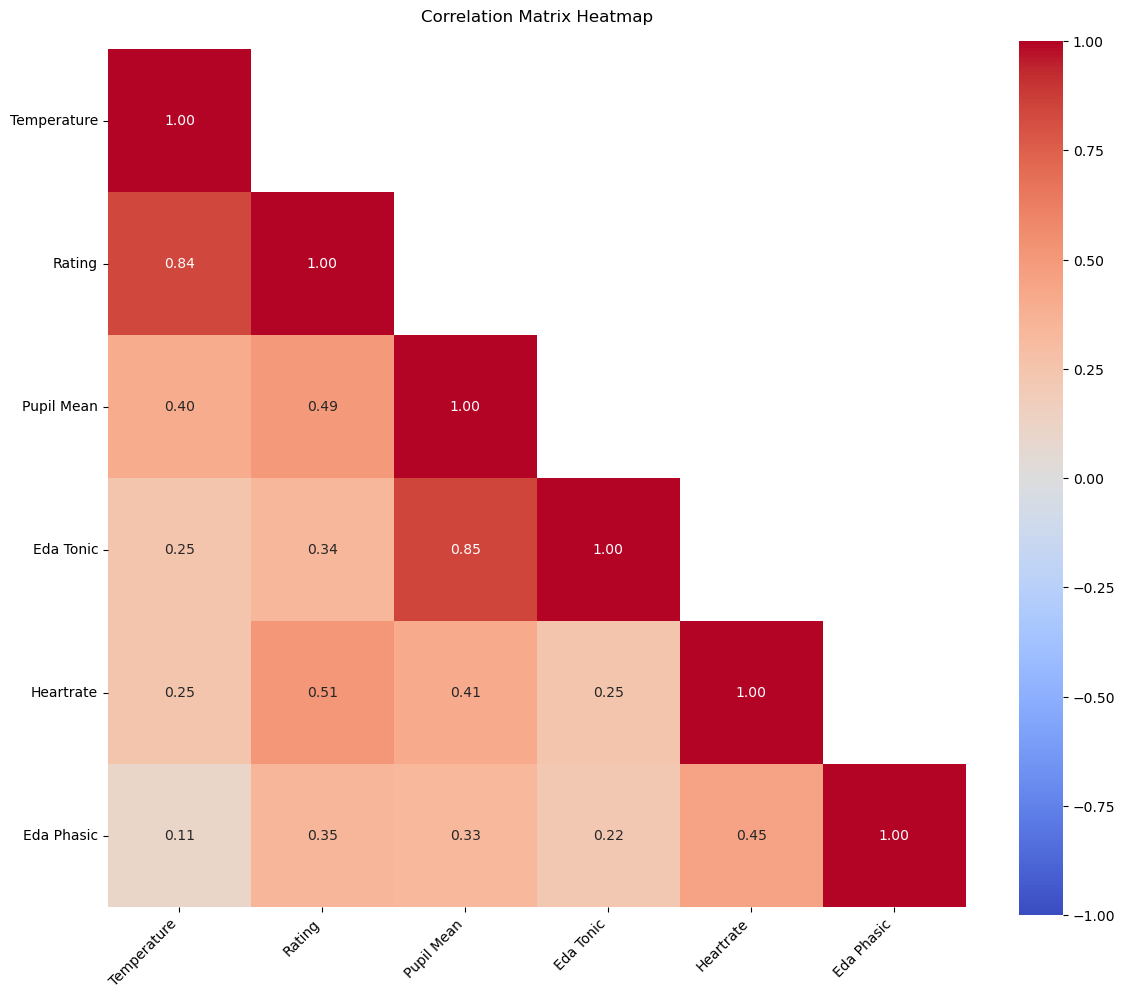

In [10]:
import polars as pl
import seaborn as sns

corr_matrix = (
    averages.select(col("^avg.*$"))
    .drop("avg_pupil_mean_tonic")
    .select(  # reorder columns
        "avg_temperature",
        "avg_rating",
        "avg_pupil_mean",
        "avg_eda_tonic",
        "avg_heartrate",
        "avg_eda_phasic",
    )
    .corr()
)
labels = [
    col.replace("avg_", "").replace("_", " ").title() for col in corr_matrix.columns
]
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix), k=1)
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",  # Color scheme from red (negative) to blue (positive)
    center=0,  # Center the colormap at 0
    fmt=".2f",  # Show 2 decimal places
    square=True,
    vmin=-1,
    vmax=1,  # Set the color scale from -1 to 1
    xticklabels=labels,
    yticklabels=labels,
    mask=mask,
)
# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Correlation Matrix Heatmap", pad=20)
plt.tight_layout()
plt.show()

In [11]:
# Sample code for correlations for each stimulus seed with standard deviation
correlations = []
for group in averages.group_by("stimulus_seed"):
    corr = group[1].select(pl.corr("avg_pupil_mean", "avg_eda_phasic")).item()
    correlations.append(corr)
correlations = np.array(correlations)
correlations.mean().round(2), correlations.std().round(2)
correlations

array([0.30010347, 0.38758943, 0.35651434, 0.41350918, 0.38841337,
       0.33269533, 0.3807507 , 0.33048362, 0.41234622, 0.38463278,
       0.37608772, 0.28926182])

## Cross correlation lags of grand means

In [12]:
for sig in signals:
    if sig == "temperature":
        continue
    col1 = "avg_temperature"
    col2 = f"avg_{sig}"
    calculate_max_crosscorr_lag_over_averages(
        averages,
        col1,
        col2,
        fs=10,
    )

10:37:39 | INFO    | averages_over_stimulus_seeds | avg_temperature : avg_rating | mean lag: -0.63, std lag: 0.47
10:37:39 | INFO    | averages_over_stimulus_seeds | avg_temperature : avg_heartrate | mean lag: 0.16, std lag: 2.09
10:37:39 | INFO    | averages_over_stimulus_seeds | avg_temperature : avg_pupil_mean | mean lag: 1.23, std lag: 0.76
10:37:39 | INFO    | averages_over_stimulus_seeds | avg_temperature : avg_pupil_mean_tonic | mean lag: 1.27, std lag: 0.77
10:37:39 | INFO    | averages_over_stimulus_seeds | avg_temperature : avg_eda_tonic | mean lag: -0.05, std lag: 0.86
10:37:39 | INFO    | averages_over_stimulus_seeds | avg_temperature : avg_eda_phasic | mean lag: -2.35, std lag: 1.16
